In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tesla-stock-price/Tesla.csv - Tesla.csv.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
dataset = pd.DataFrame(pd.read_csv("/kaggle/input/tesla-stock-price/Tesla.csv - Tesla.csv.csv"))

In [4]:
dataset.shape

(1692, 7)

In [5]:
dataset.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [6]:
dataset.tail()

,Date,Open,High,Low,Close,Volume,Adj Close
1687,3/13/2017,244.820007,246.850006,242.779999,246.169998,3010700,246.169998
1688,3/14/2017,246.110001,258.119995,246.020004,258.000000,7575500,258.000000
1689,3/15/2017,257.000000,261.000000,254.270004,255.729996,4816600,255.729996
1690,3/16/2017,262.399994,265.750000,259.059998,262.049988,7100400,262.049988
1691,3/17/2017,264.000000,265.329987,261.200012,261.500000,6475900,261.500000


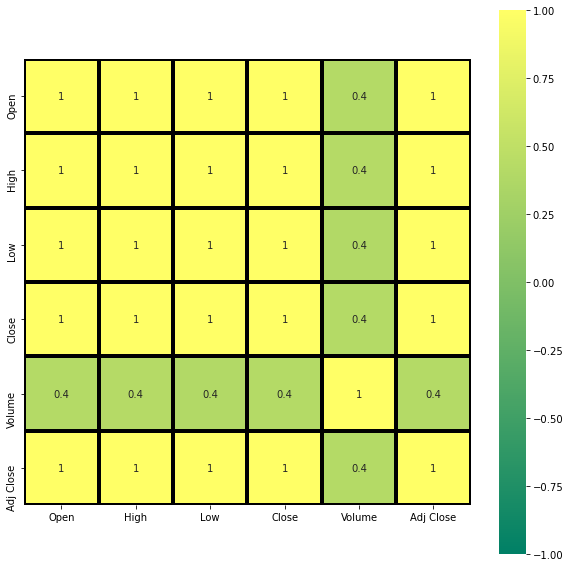

In [7]:
# check for any correlation
plt.figure(figsize = (10,10))
sns.heatmap(dataset.corr(), annot = True, fmt = ".1g", vmin = -1, vmax = 1, center = 0, linewidth = 3,
           linecolor = "black", square = True, cmap = "summer")

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1692 non-null   object 
 1   Open       1692 non-null   float64
 2   High       1692 non-null   float64
 3   Low        1692 non-null   float64
 4   Close      1692 non-null   float64
 5   Volume     1692 non-null   int64  
 6   Adj Close  1692 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 92.7+ KB


There is no missing value. We have full entry.

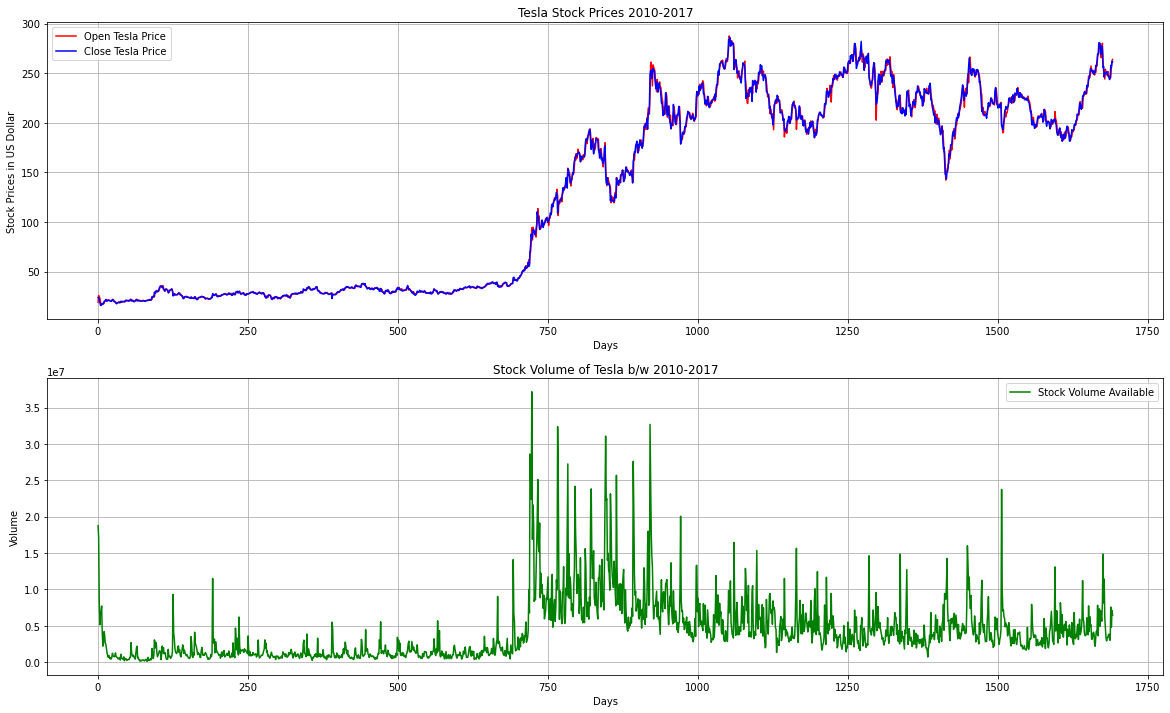

In [9]:
plt.figure(figsize = (20, 12))
x = np.arange(0, dataset.shape[0], 1)
plt.subplot(2,1,1)
plt.plot(x, dataset.Open.values, color = "red", label = "Open Tesla Price")
plt.plot(x, dataset.Close.values, color = "blue", label = "Close Tesla Price")
plt.title("Tesla Stock Prices 2010-2017")
plt.xlabel("Days")
plt.ylabel("Stock Prices in US Dollar")
plt.legend(loc = "best")
plt.grid(which = "major", axis = "both")

plt.subplot(2,1,2)
plt.plot(x, dataset.Volume.values, color = "green", label = "Stock Volume Available")
plt.title("Stock Volume of Tesla b/w 2010-2017")
plt.xlabel("Days")
plt.ylabel("Volume")
plt.legend(loc = "best")
plt.grid(which = "major", axis = "both")
plt.show()

We will construct 3 models. One for predicting the opening price and the other for closing price. Also, we will try to find the stock volume available on that day.

In [10]:
TIME_STEP = 5
DAYS = 20 # number of days at the end for which we have to predict. These will be in our validation set.

In [11]:
dataset = pd.DataFrame(pd.read_csv("/kaggle/input/tesla-stock-price/Tesla.csv - Tesla.csv.csv"))

In [12]:
def dataset_split(dataset) : 
    train = dataset[0: len(dataset) - DAYS]
    val = dataset[len(dataset) - DAYS - TIME_STEP : len(dataset)]
    return train, val

In [13]:
dataset.drop(["Date","High", "Low", "Close", "Volume", "Adj Close"], axis = 1, inplace = True)
dataset = dataset.values

In [14]:
import sklearn
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
dataset_scaled = scaler.fit_transform(dataset)

In [15]:
train, val = dataset_split(dataset_scaled)

In [16]:
train.shape, val.shape

((1672, 1), (25, 1))

In [17]:
train_x, train_y = [], []
for i in range(TIME_STEP, train.shape[0]) : 
    train_x.append(train[i - TIME_STEP : i, 0])
    train_y.append(train[i, 0])
train_x, train_y = np.array(train_x), np.array(train_y)

In [18]:
val_x, val_y = [], []
for i in range(TIME_STEP, val.shape[0]) : 
    val_x.append(val[i - TIME_STEP : i, 0])
    val_y.append(val[i, 0])
val_x, val_y = np.array(val_x), np.array(val_y)

In [19]:
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
val_x = np.reshape(val_x, (val_x.shape[0], val_x.shape[1], 1))
print("Reshaped train_x = ", train_x.shape)
print("Shape of train_y = ", train_y.shape)

print("Reshaped val_x = ", val_x.shape)
print("Shape of val_y = ", val_y.shape)

Reshaped train_x =  (1667, 5, 1)
Shape of train_y =  (1667,)
Reshaped val_x =  (20, 5, 1)
Shape of val_y =  (20,)


In [20]:
import tensorflow as tf

In [21]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpus = tf.config.list_physical_devices("GPU")
print(gpus)
if len(gpus) == 1 : 
    strategy = tf.distribute.OneDeviceStrategy(device = "/gpu:0")
else:
    strategy = tf.distribute.MirroredStrategy()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [22]:
tf.config.optimizer.set_experimental_options({"auto_mixed_precision" : True})
print("Mixed precision enabled")

Mixed precision enabled


In [23]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor= "loss", factor = 0.5, patience = 10,
                                                 min_lr = 0.000001, verbose = 1)
monitor_es = tf.keras.callbacks.EarlyStopping(monitor= "loss", patience = 25, restore_best_weights= False, verbose = True)

In [24]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units = 128, return_sequences = True, input_shape = (train_x.shape[1], 1)))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.LSTM(units = 128, return_sequences = True))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.LSTM(units = 128, return_sequences = True))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.LSTM(units = 128, return_sequences = False))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(units = 20, activation = "relu"))
model.add(tf.keras.layers.Dense(units = 1, activation = "relu"))

In [25]:
model.compile(tf.keras.optimizers.Adam(lr = 0.001), loss = "mean_squared_error")

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 128)            66560     
_________________________________________________________________
dropout (Dropout)            (None, 5, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 128)            131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 128)            131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 128)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               1

In [27]:
with tf.device("/device:GPU:0"):
    history = model.fit(train_x, train_y, epochs = 300, batch_size = 16, callbacks = [reduce_lr, monitor_es])

Epoch 1/300
105/105 [==============================] - 1s 7ms/step - loss: 0.0318 - lr: 0.0010
Epoch 2/300
105/105 [==============================] - 1s 7ms/step - loss: 0.0050 - lr: 0.0010
Epoch 3/300
105/105 [==============================] - 1s 7ms/step - loss: 0.0040 - lr: 0.0010
Epoch 4/300
105/105 [==============================] - 1s 7ms/step - loss: 0.0036 - lr: 0.0010
Epoch 5/300
105/105 [==============================] - 1s 7ms/step - loss: 0.0035 - lr: 0.0010
Epoch 6/300
105/105 [==============================] - 1s 14ms/step - loss: 0.0037 - lr: 0.0010
Epoch 7/300
105/105 [==============================] - 1s 8ms/step - loss: 0.0032 - lr: 0.0010
Epoch 8/300
105/105 [==============================] - 1s 9ms/step - loss: 0.0027 - lr: 0.0010
Epoch 9/300
105/105 [==============================] - 1s 8ms/step - loss: 0.0025 - lr: 0.0010
Epoch 10/300
105/105 [==============================] - 1s 8ms/step - loss: 0.0026 - lr: 0.0010
Epoch 11/300
105/105 [==========================

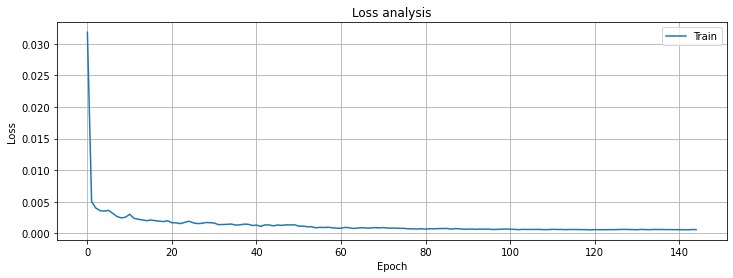

In [28]:
plt.figure(figsize = (12, 4))
plt.plot(history.history["loss"], label = "Training loss")
plt.title("Loss analysis")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train"])
plt.grid("both")

In [29]:
real_prices = val[TIME_STEP:]
real_prices = scaler.inverse_transform(real_prices)

In [30]:
predicted_prices = model.predict(val_x)
predicted_prices = scaler.inverse_transform(predicted_prices)

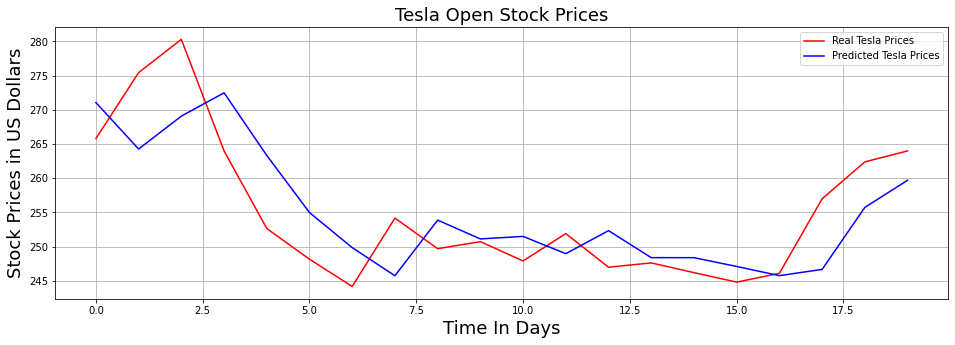

In [31]:
plt.figure(figsize= (16, 5))
plt.subplot(1,1,1)

x = np.arange(0, DAYS, 1)

plt.plot(x, real_prices, color = "red", label = "Real Tesla Prices")
plt.plot(x, predicted_prices, color = "blue", label = "Predicted Tesla Prices")
plt.title("Tesla Open Stock Prices", fontsize = 18)
plt.xlabel("Time In Days", fontsize = 18)
plt.ylabel("Stock Prices in US Dollars", fontsize = 18)
plt.legend()
plt.grid("both")

In [32]:
original_training_prices = scaler.inverse_transform(train)
original_training_prices

array([[ 19.      ],
       [ 25.790001],
       [ 25.      ],
       ...,
       [279.029999],
       [280.      ],
       [277.600006]])

In [33]:
x1 = np.arange(0,len(original_training_prices),1)
x2 = np.arange(len(original_training_prices), len(dataset), 1)
print(len(x1), len(x2))

1672 20


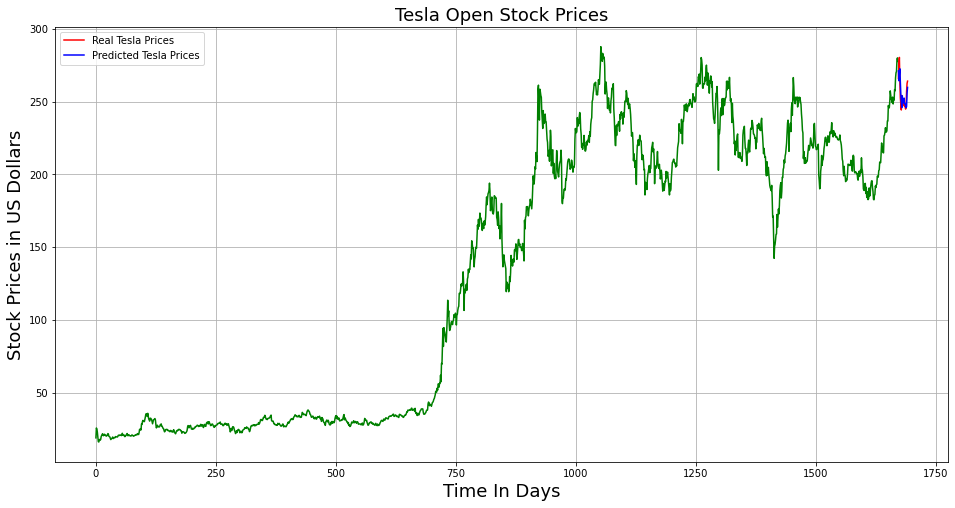

In [34]:
plt.figure(figsize= (16,8))
plt.subplot(1,1,1)

X = len(dataset)
x1 = np.arange(0,len(original_training_prices),1)
x2 = np.arange(len(original_training_prices), len(dataset), 1)

plt.plot(x1, original_training_prices, color = "green")
plt.plot(x2, real_prices, color = "red", label = "Real Tesla Prices")
plt.plot(x2, predicted_prices, color = "blue", label = "Predicted Tesla Prices")
plt.title("Tesla Open Stock Prices", fontsize = 18)
plt.xlabel("Time In Days", fontsize = 18)
plt.ylabel("Stock Prices in US Dollars", fontsize = 18)
plt.legend()
plt.grid("both")

In [35]:
model_json = model.to_json()
with open("tesla_open_1.json", "w") as json_file:
  json_file.write(model_json)

model.save_weights("tesla_open_1.h5")